# Lezen van de files

Importeren libraries

In [1]:
import h5py
import os
import numpy as np
import random


Hier 1 class van maken, doet:
* lezen van de data
* Specificeren van de folder waarvan je de data wil inlezen in folder

## Class voor all preprocess stappen

### Inlezen CROSS


In [2]:
# Inladen voor INTRA
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X_test1, X_test2, X_test3 = np.load('/content/drive/MyDrive/PRDL_final/arrays/X_test1_reshaped.npy'), np.load('/content/drive/MyDrive/PRDL_final/arrays/X_test2_reshaped.npy'), np.load('/content/drive/MyDrive/PRDL_final/arrays/X_test3_reshaped.npy')
X_train = np.load('/content/drive/MyDrive/PRDL_final/arrays/X_train.npy')

y_test1, y_test2, y_test3 = np.load('/content/drive/MyDrive/PRDL_final/arrays/y_test1.npy'), np.load('/content/drive/MyDrive/PRDL_final/arrays/y_test2.npy'), np.load('/content/drive/MyDrive/PRDL_final/arrays/y_test3.npy')
y_train  = np.load('/content/drive/MyDrive/PRDL_final/arrays/y_train.npy')



In [4]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=4)
y_test1_encoded, y_test2_encoded, y_test3_encoded = to_categorical(y_test1, num_classes=4), to_categorical(y_test2, num_classes=4), to_categorical(y_test3, num_classes=4)

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Trainen + Maken van het model (intra)

### LSTM met hyperparametertuning

In [6]:
!pip3 install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.8 MB/s eta 0:00:00


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

def build_model_storedParams(loaded_hyperparameters): # dit is de versie die met json params verder gaat
    model = Sequential()

    # Adding LSTM layers as per loaded hyperparameters
    for i in range(loaded_hyperparameters['num_lstm_layers']):
        model.add(LSTM(
            units=loaded_hyperparameters[f'units_{i}'],
            return_sequences=i < loaded_hyperparameters['num_lstm_layers'] - 1,
            input_shape=(X_train.shape[1], X_train.shape[2]),
            dropout=loaded_hyperparameters.get('lstm_dropout_', 0)))

    # Adding Dense layers as per loaded hyperparameters
    for i in range(loaded_hyperparameters['num_dense_layers']):
        model.add(Dense(
            units=loaded_hyperparameters[f'dense_units_{i}'],
            activation='relu'))

    model.add(Dense(4, activation='softmax'))  # 4 classes

    model.compile(
        optimizer=tf.keras.optimizers.Adam(loaded_hyperparameters['learning_rate']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


def build_model(hp):
    model = Sequential()

    # Tuning the number of LSTM layers and their units
    for i in range(hp.Int('num_lstm_layers', 1, 4)):
        model.add(LSTM(
            units=hp.Choice('units_' + str(i), values=[16, 32, 64, 128]), #values=[16, 32, 64, 128]
            return_sequences=i < hp.get('num_lstm_layers') - 1,  # Only the last layer should not return sequences
            input_shape=(X_train.shape[1], X_train.shape[2]),
            dropout=hp.Choice('lstm_dropout_', values=[0.1, 0.2, 0.3, 0.4, 0.5]),
            kernel_regularizer=l2(hp.Choice('lstm_kernel_regularizer_', values=[1e-3, 1e-4, 1e-5]))))

    # Tuning the number of Dense layers and their units
    for i in range(hp.Int('num_dense_layers', 1, 4)):
        model.add(Dense(
            units=hp.Choice('dense_units_' + str(i), values=[16, 32, 64, 128]), #values=[16, 32, 64, 128]
            activation='relu',
            kernel_regularizer=l2(hp.Choice('dense_kernel_regularizer_', values=[1e-3, 1e-4, 1e-5]))))

    model.add(Dense(4, activation='softmax'))  # 4 classes

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), #values=[1e-2, 1e-3, 1e-4]
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='./',
    project_name='hparam_tuning'
)

tuner.search_space_summary()

# Start the hyperparameter tuning
tuner.search(X_train, y_train_encoded, epochs=10, batch_size=8, validation_data=(X_test1, y_test1_encoded))
# epochs + batch size voor nu constant (behalve epochs bij fitten van model)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 10 Complete [00h 04m 14s]
val_accuracy: 0.4583333333333333

Best val_accuracy So Far: 0.4791666666666667
Total elapsed time: 00h 38m 20s


In [8]:
# voor normale getuned params
print(f"""
The hyperparameter search is complete.
The optimal number of LSTM and Dense layers and their units can be reviewed in the best hyperparameters.
""")

## Early stopping om te kijken of het effect heeft om het aantal epochs te verhogen
# Early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Increase the number of epochs as needed
epochs = 50
# Build the model with the optimal hyperparameters and train it

model = tuner.hypermodel.build(best_hps) ### HIER SWITCHEN NAAR BESTE HYPER PARAMETERS OF INLADEN VIA JSON loaded_hyperparameters

#model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test)) # epochs aanpassen voor snelheid
# deze was redelijk:
#model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded)) # kleinere batch size kan miss helpen? sotnd eerst op 64

model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=32, validation_data=(X_test1, y_test1_encoded), callbacks=[early_stopping_callback])

# beste model als callback opslaan met .h5 of best params opslaan als file


The hyperparameter search is complete.
The optimal number of LSTM and Dense layers and their units can be reviewed in the best hyperparameters.

Epoch 1/50
2/2 [==============================] - 15s 3s/step - loss: 1.4105 - accuracy: 0.2031 - val_loss: 1.4070 - val_accuracy: 0.1875
Epoch 2/50
2/2 [==============================] - 3s 2s/step - loss: 1.4060 - accuracy: 0.3438 - val_loss: 1.4044 - val_accuracy: 0.2500
Epoch 3/50
2/2 [==============================] - 3s 2s/step - loss: 1.4007 - accuracy: 0.3750 - val_loss: 1.4025 - val_accuracy: 0.1875
Epoch 4/50
2/2 [==============================] - 3s 2s/step - loss: 1.3919 - accuracy: 0.3906 - val_loss: 1.4007 - val_accuracy: 0.1875
Epoch 5/50
2/2 [==============================] - 3s 2s/step - loss: 1.3782 - accuracy: 0.4062 - val_loss: 1.3955 - val_accuracy: 0.1875
Epoch 6/50
2/2 [==============================] - 3s 2s/step - loss: 1.3725 - accuracy: 0.3438 - val_loss: 1.3850 - val_accuracy: 0.1875
Epoch 7/50
2/2 [===============

### Save / Store hyper params

In [9]:
## To see the best hyper params + valuesL:
print("Best Hyperparameters:")
for hyperparam in best_hps.values:
    print(f"{hyperparam}: {best_hps.get(hyperparam)}")


Best Hyperparameters:
num_lstm_layers: 4
units_0: 128
lstm_dropout_: 0.2
lstm_kernel_regularizer_: 1e-05
num_dense_layers: 4
dense_units_0: 64
dense_kernel_regularizer_: 0.0001
learning_rate: 0.001
units_1: 64
units_2: 32
dense_units_1: 32
dense_units_2: 16
units_3: 128
dense_units_3: 64


In [11]:
# ALLEEN OPSLAAN ALS NODUIG
# save hyper params in file (als hoge accuracy)
import json
type(best_hps.values)


dict

In [12]:
# Write the dictionary to a JSON file
with open('best_hyperparameters.json', 'w') as file:
    json.dump(best_hps.values, file)

In [13]:
# Load best hyper params:
# Read the hyperparameters from the JSON file
with open('./best_hyperparameters.json', 'r') as file:
    loaded_hyperparameters = json.load(file)

# Now `loaded_hyperparameters` contains the hyperparameters


In [14]:
loaded_hyperparameters

{'num_lstm_layers': 4,
 'units_0': 128,
 'lstm_dropout_': 0.2,
 'lstm_kernel_regularizer_': 1e-05,
 'num_dense_layers': 4,
 'dense_units_0': 64,
 'dense_kernel_regularizer_': 0.0001,
 'learning_rate': 0.001,
 'units_1': 64,
 'units_2': 32,
 'dense_units_1': 32,
 'dense_units_2': 16,
 'units_3': 128,
 'dense_units_3': 64}

In [15]:
# model draaien op json hyper params (opgeslagen)
model = build_model_storedParams(loaded_hyperparameters)

epochs = 50  # or any other number of epochs you want
batch_size = 8  # or any other batch size you want

# Early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_train, y_train_encoded,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test1, y_test1_encoded),
    callbacks=[early_stopping_callback]
)


Epoch 1/50
8/8 [==============================] - 18s 1s/step - loss: 1.3899 - accuracy: 0.2188 - val_loss: 1.3814 - val_accuracy: 0.4375
Epoch 2/50
8/8 [==============================] - 9s 1s/step - loss: 1.3807 - accuracy: 0.3281 - val_loss: 1.3786 - val_accuracy: 0.3750
Epoch 3/50
8/8 [==============================] - 7s 932ms/step - loss: 1.3751 - accuracy: 0.3594 - val_loss: 1.3716 - val_accuracy: 0.3125
Epoch 4/50
8/8 [==============================] - 8s 1s/step - loss: 1.3426 - accuracy: 0.3906 - val_loss: 1.3748 - val_accuracy: 0.3125
Epoch 5/50
8/8 [==============================] - 8s 1s/step - loss: 1.2781 - accuracy: 0.4062 - val_loss: 1.3770 - val_accuracy: 0.2500
Epoch 6/50
8/8 [==============================] - 8s 1s/step - loss: 1.1785 - accuracy: 0.4062 - val_loss: 1.2600 - val_accuracy: 0.3125
Epoch 7/50
8/8 [==============================] - 8s 1s/step - loss: 1.3574 - accuracy: 0.4219 - val_loss: 1.3757 - val_accuracy: 0.2500
Epoch 8/50
8/8 [=====================

In [16]:
X_test_off = np.concatenate((X_test2, X_test3), axis=0)
y_test_off = np.concatenate((y_test2_encoded, y_test3_encoded), axis=0)

1/1 [==============================] - 6s 6s/step
[1 1 1 1 1 1 1 3 3 1 1 1 1 1 1 3 1 1 1 1 3 1 1 3 1 2 1 3 3 1 1 2]


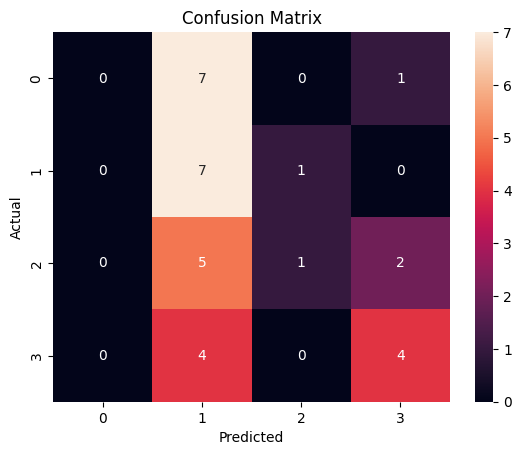

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.30      0.88      0.45         8
           2       0.50      0.12      0.20         8
           3       0.57      0.50      0.53         8

    accuracy                           0.38        32
   macro avg       0.34      0.38      0.30        32
weighted avg       0.34      0.38      0.30        32



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test_off)
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred_classes)
# Confusion Matrix
cm = confusion_matrix(np.argmax(y_test_off, axis=1), y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report for additional metrics
print(classification_report(np.argmax(y_test_off, axis=1), y_pred_classes))


In [18]:
# Evaluating the model on the training data
train_loss, train_accuracy = model.evaluate(X_train, y_train_encoded)
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

# Evaluating the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_off, y_test_off)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


2/2 [==============================] - 3s 448ms/step - loss: 1.1086 - accuracy: 0.4688
Training Accuracy: 46.88%
1/1 [==============================] - 1s 891ms/step - loss: 1.3460 - accuracy: 0.3750
Test Accuracy: 37.50%


# opmerkingen INTRA

* train acc is 50%
* test acc 75%
* hyper params gevonden mbv hyper parameter tuning
* daarna deze waardes opgeslagen in json file
* model gefit mbv deze params
* epochs / batch sizes zouden nog getuned/getest kunnen worden

Zelfde wordt nu gedaan voor CROSS

Hierna statistische test doen op beide uitkomsten om te bepalen of er significantie is tussen de twee classificatie methoden.